In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from helpers import *
from utils import *
from implementations import *
%load_ext autoreload
%autoreload 2

# Exploratory Data Analysis
## Data Overview

First we should quickly see how train and test data look like and if they follow similar distribution

In [2]:
path_dataset = 'resources/train.csv'
y, X, ids = load_csv_data(path_dataset)

In [3]:
print(f'training Dataset X shape is {X.shape}')
print(f'ground truth labels y shape is {y.shape}')

training Dataset X shape is (250000, 30)
ground truth labels y shape is (250000,)


In [4]:
full_data = np.c_[X,y]

To understand data more easily, here we get the feature name from train.csv

In [5]:
N_feature = X.shape[1]

columns = np.genfromtxt(path_dataset, delimiter=",",dtype=str)[0]
columns = columns.tolist()
features_name = columns[2:]
features_name


['DER_mass_MMC',
 'DER_mass_transverse_met_lep',
 'DER_mass_vis',
 'DER_pt_h',
 'DER_deltaeta_jet_jet',
 'DER_mass_jet_jet',
 'DER_prodeta_jet_jet',
 'DER_deltar_tau_lep',
 'DER_pt_tot',
 'DER_sum_pt',
 'DER_pt_ratio_lep_tau',
 'DER_met_phi_centrality',
 'DER_lep_eta_centrality',
 'PRI_tau_pt',
 'PRI_tau_eta',
 'PRI_tau_phi',
 'PRI_lep_pt',
 'PRI_lep_eta',
 'PRI_lep_phi',
 'PRI_met',
 'PRI_met_phi',
 'PRI_met_sumet',
 'PRI_jet_num',
 'PRI_jet_leading_pt',
 'PRI_jet_leading_eta',
 'PRI_jet_leading_phi',
 'PRI_jet_subleading_pt',
 'PRI_jet_subleading_eta',
 'PRI_jet_subleading_phi',
 'PRI_jet_all_pt']

In [6]:
_,X_Test,ids = load_csv_data('resources/test.csv')
print(f'test Dataset X shape is {X_Test.shape}')

test Dataset X shape is (568238, 30)


### Data Distribution

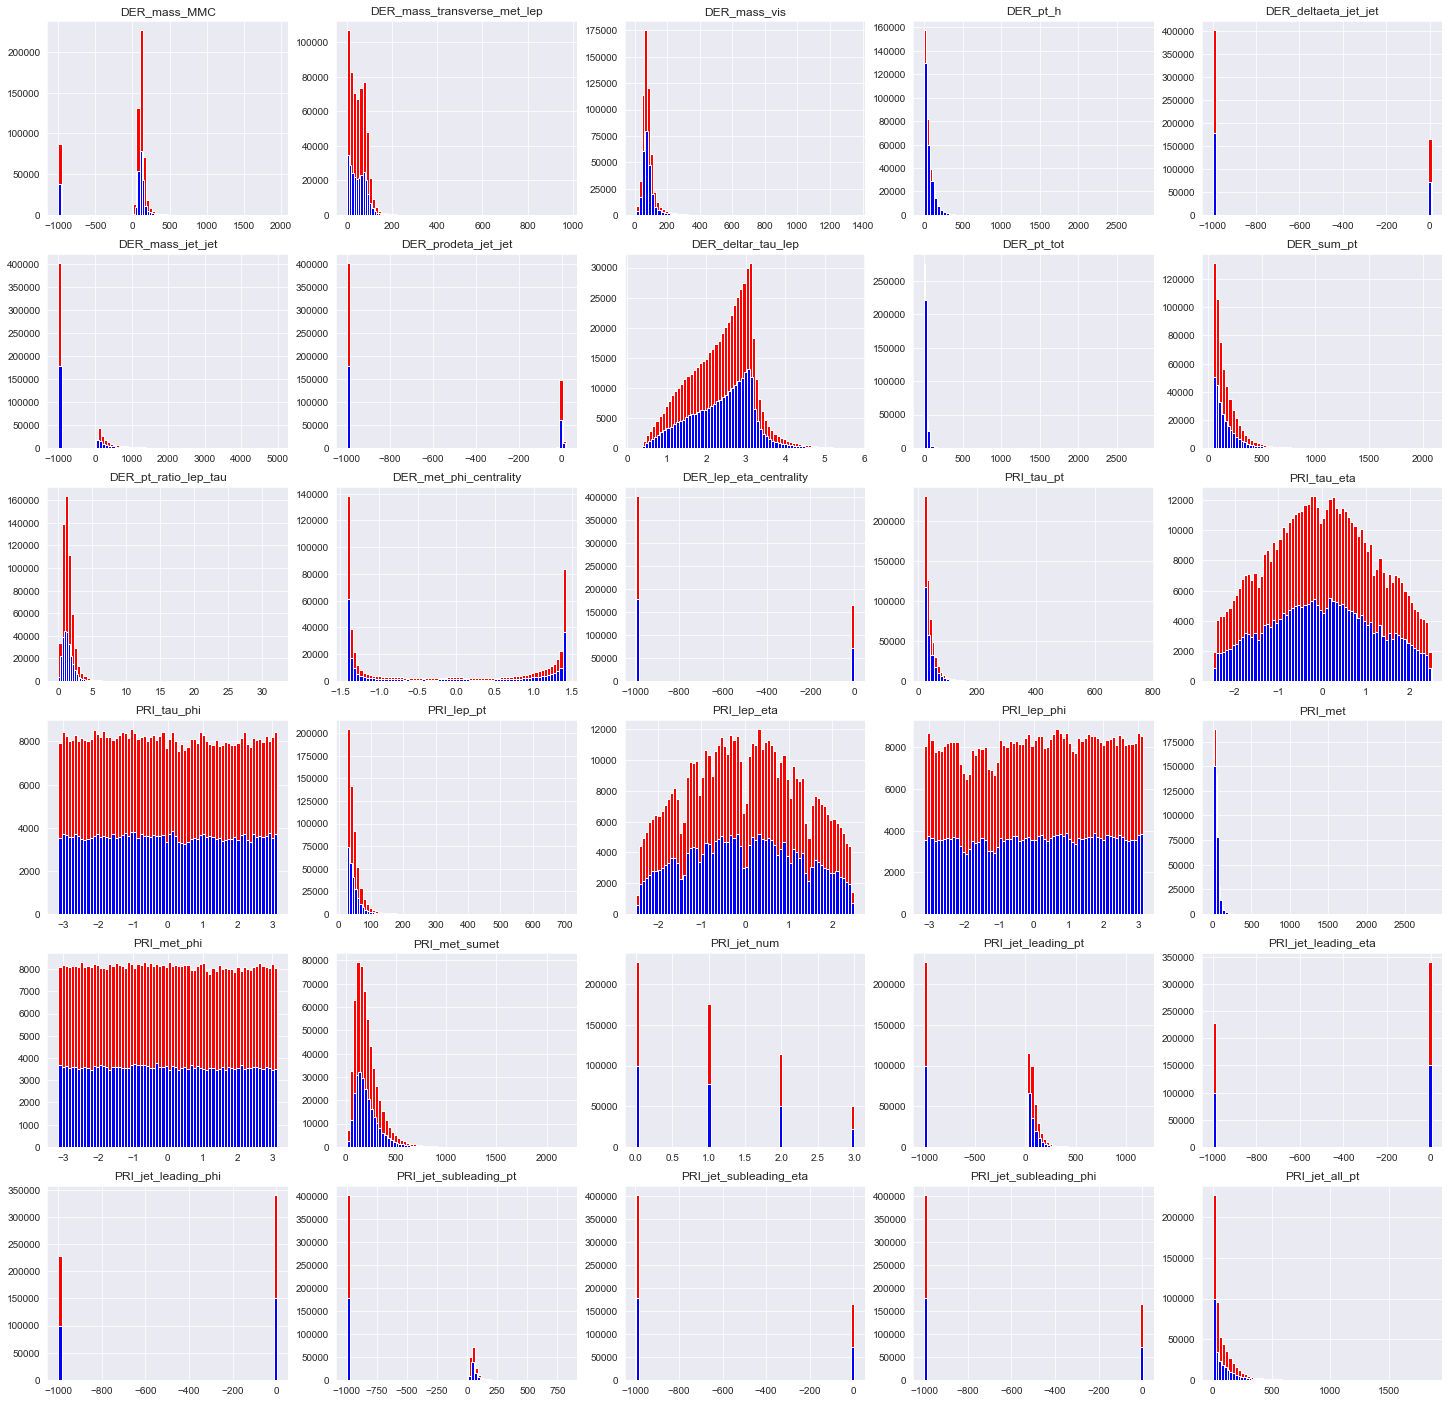

In [8]:
N_feature = X.shape[1]
plt.subplots(figsize=(25,25))
for i in range(0, N_feature):
    plt.subplot(6,5,i+1).set_title(features_name[i])
    # sns.histplot(X[:,i], bins = 70).set(title=features_name[i])
    plt.hist(X_Test[:,i] ,70, histtype ='bar',color='r')
    plt.hist(X[:,i] ,bins = 70, histtype ='bar',color='b')


From plot above we can see the train and test data follow similar distribution. However, the plots tell us that there are some columns that are heavily skewed. Therefore a log-scale transform might be useful in this case.

We also noticed here the column 22 `PRI_jet_num` have only integer value `0,1,2,3`, which might be recognized as categorical feature

<AxesSubplot:>

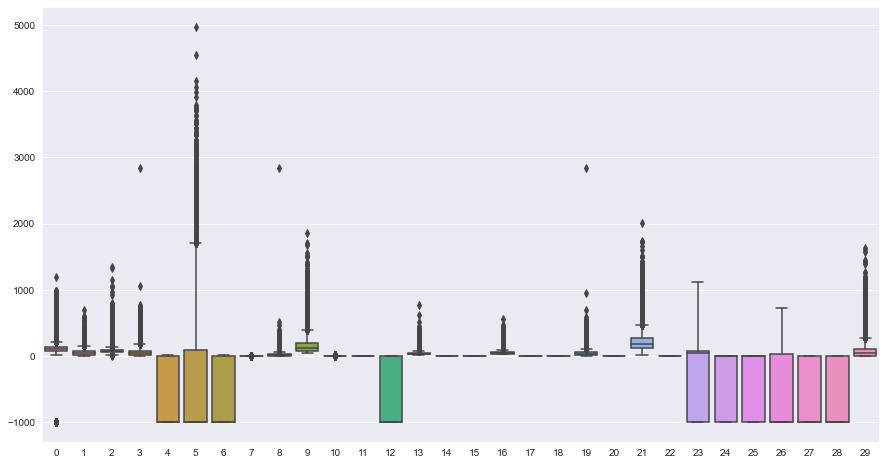

In [9]:
plt.figure(figsize=(15,8))
sns.boxplot(X)

<AxesSubplot:>

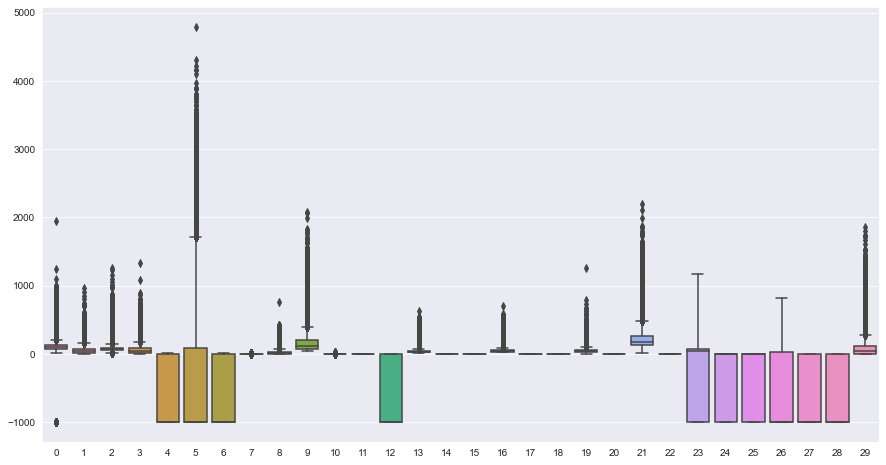

In [53]:
plt.figure(figsize=(15, 8))
sns.boxplot(X_Test)

From the above box plot, we can find there are few outliers that are really far away, one preprocess is to remove them in train data. Since test data also have some outliers, in training we only remove the 'extreme' outliers.

## Missing Values

We noticed there are a lot of `-999` in the data, which represent the missing value. They could have huge influence on the training result.

In [54]:
# get column index that have missing value
columns_with_missing_features = np.where(np.any(X==-999, axis=0))[0]
columns_with_missing_features

array([ 0,  4,  5,  6, 12, 23, 24, 25, 26, 27, 28])

In [11]:
for i in columns_with_missing_features:
    print(f'-----column index {i}, column name {features_name[i]}-------')
    temp = X[:,i]
    y_999 = y[temp==-999]
    print(f'there are {y_999.shape[0]} missing value, which is {y_999.shape[0]/temp.shape[0]} of all sample')
    print(f'there are {y_999[y_999 == -1].shape[0]/y_999.shape[0]} of missing value is from background sample')
    print('----------------------------')


-----column index 0, column name DER_mass_MMC-------
there are 38114 missing value, which is 0.152456 of all sample
there are 0.9256178831925277 of missing value is from background sample
----------------------------
-----column index 4, column name DER_deltaeta_jet_jet-------
there are 177457 missing value, which is 0.709828 of all sample
there are 0.700197794395262 of missing value is from background sample
----------------------------
-----column index 5, column name DER_mass_jet_jet-------
there are 177457 missing value, which is 0.709828 of all sample
there are 0.700197794395262 of missing value is from background sample
----------------------------
-----column index 6, column name DER_prodeta_jet_jet-------
there are 177457 missing value, which is 0.709828 of all sample
there are 0.700197794395262 of missing value is from background sample
----------------------------
-----column index 12, column name DER_lep_eta_centrality-------
there are 177457 missing value, which is 0.709828

From the printed result we can see that `4,5,6,12,26,27,28` column have more than 70% missing value, and `24,25` have almost 75% missing value.

Also, one interesting finding is in column `0`,although there are only 15% values are missing, more that 92% of missing value are background sample. Which means if the `column 0` has missing value or not can also be a feature to predict.

## feature distributions  in different Labels

Next we compare the features distributions for the background events and the signal events in the training set. **If a feature has reasonably different distributions corresponding to the background events and the signal events, then it is a clear indication that the feature is important in the task of classifying the events when the label is unknown.**

In [7]:
# spilt background and signal sample
X_b = X[y == -1]
X_s = X[y == 1]

In [12]:
print(f'there are {y[y==-1].shape[0]} of background samples, which is {y[y==-1].shape[0]/y.shape[0]} of all sample')
print(f'there are {y[y==1].shape[0]} of signal samples, which is {y[y==1].shape[0]/y.shape[0]} of all sample')

there are 164333 of background samples, which is 0.657332 of all sample
there are 85667 of signal samples, which is 0.342668 of all sample


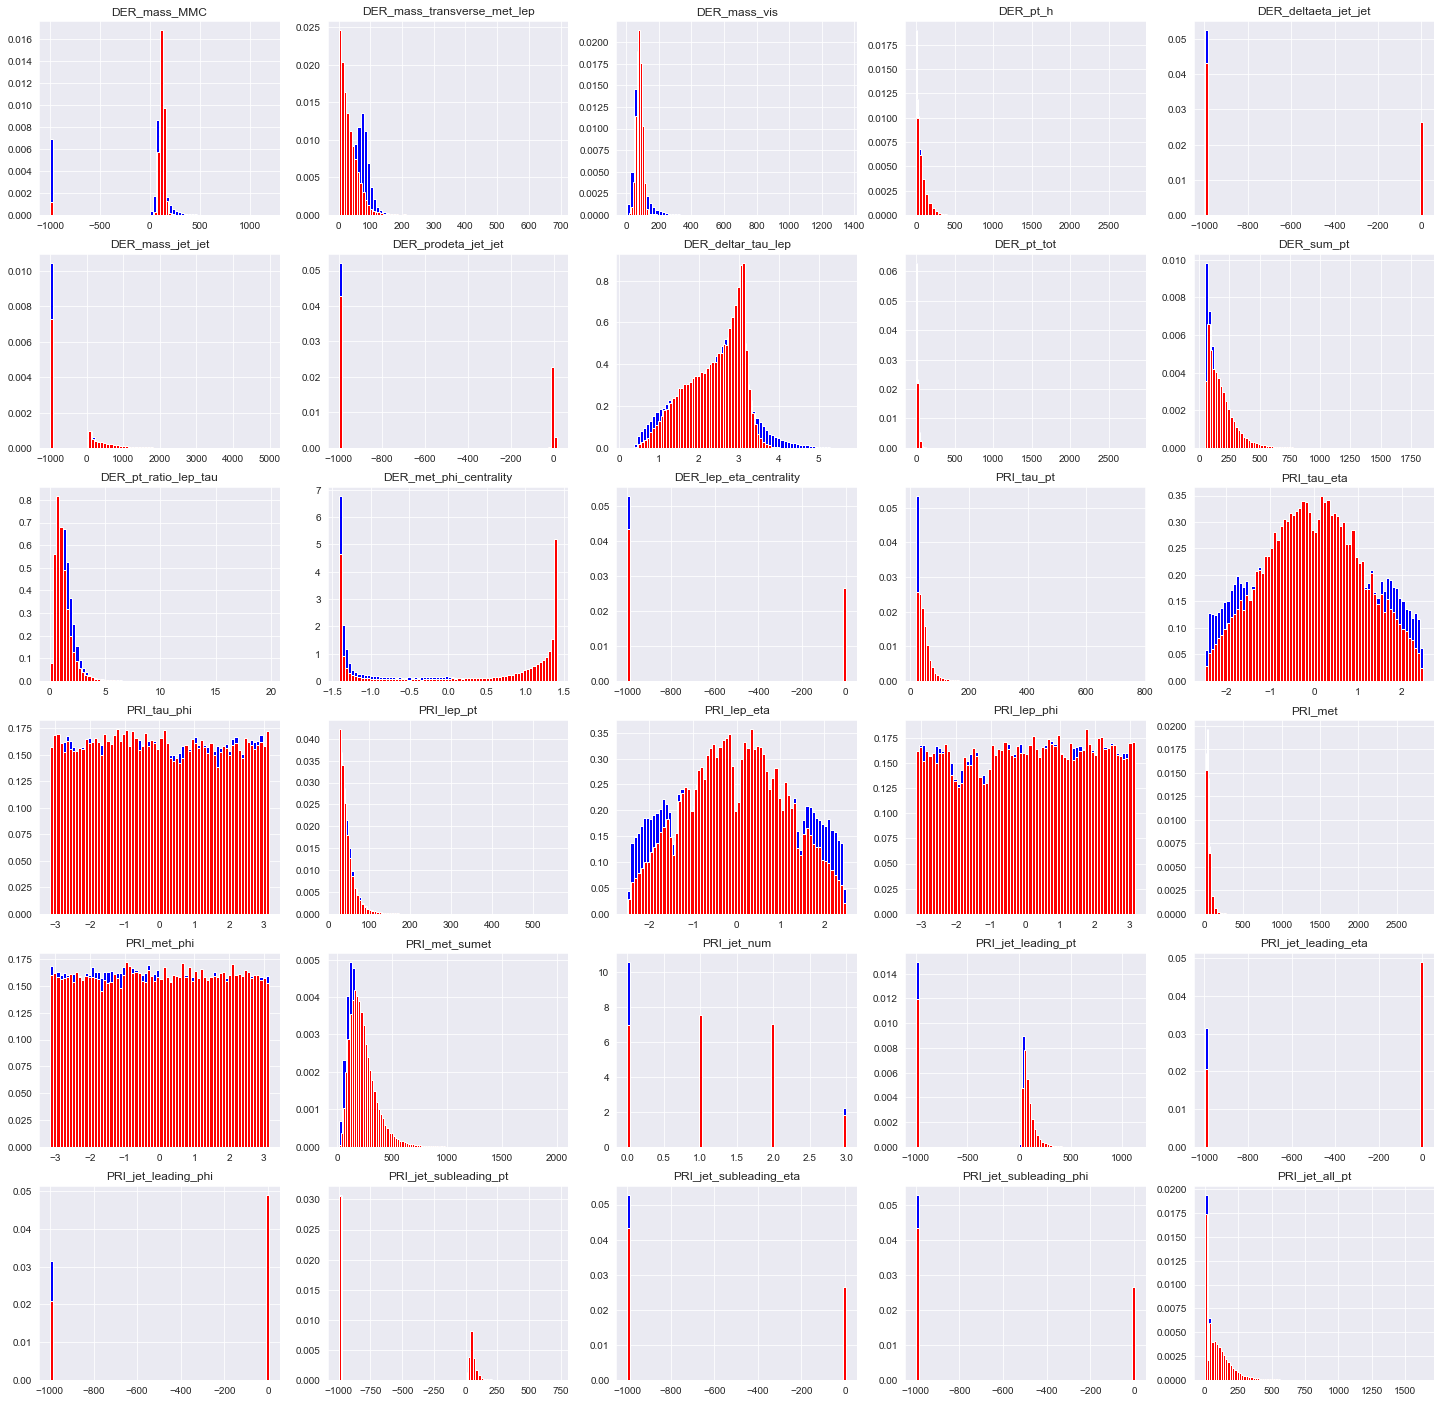

In [13]:
plt.subplots(figsize=(25,25))
X_b = X[y == -1]
X_s = X[y == 1]
for i in range(0, N_feature):
    plt.subplot(6,5,i+1).set_title(features_name[i])
    plt.hist(X_b[:,i] ,bins = 70, histtype ='bar',color='b',density=True)
    plt.hist(X_s[:,i] ,70, histtype ='bar',color='r',density=True)

We also plot the feature distribution without all the missing value.

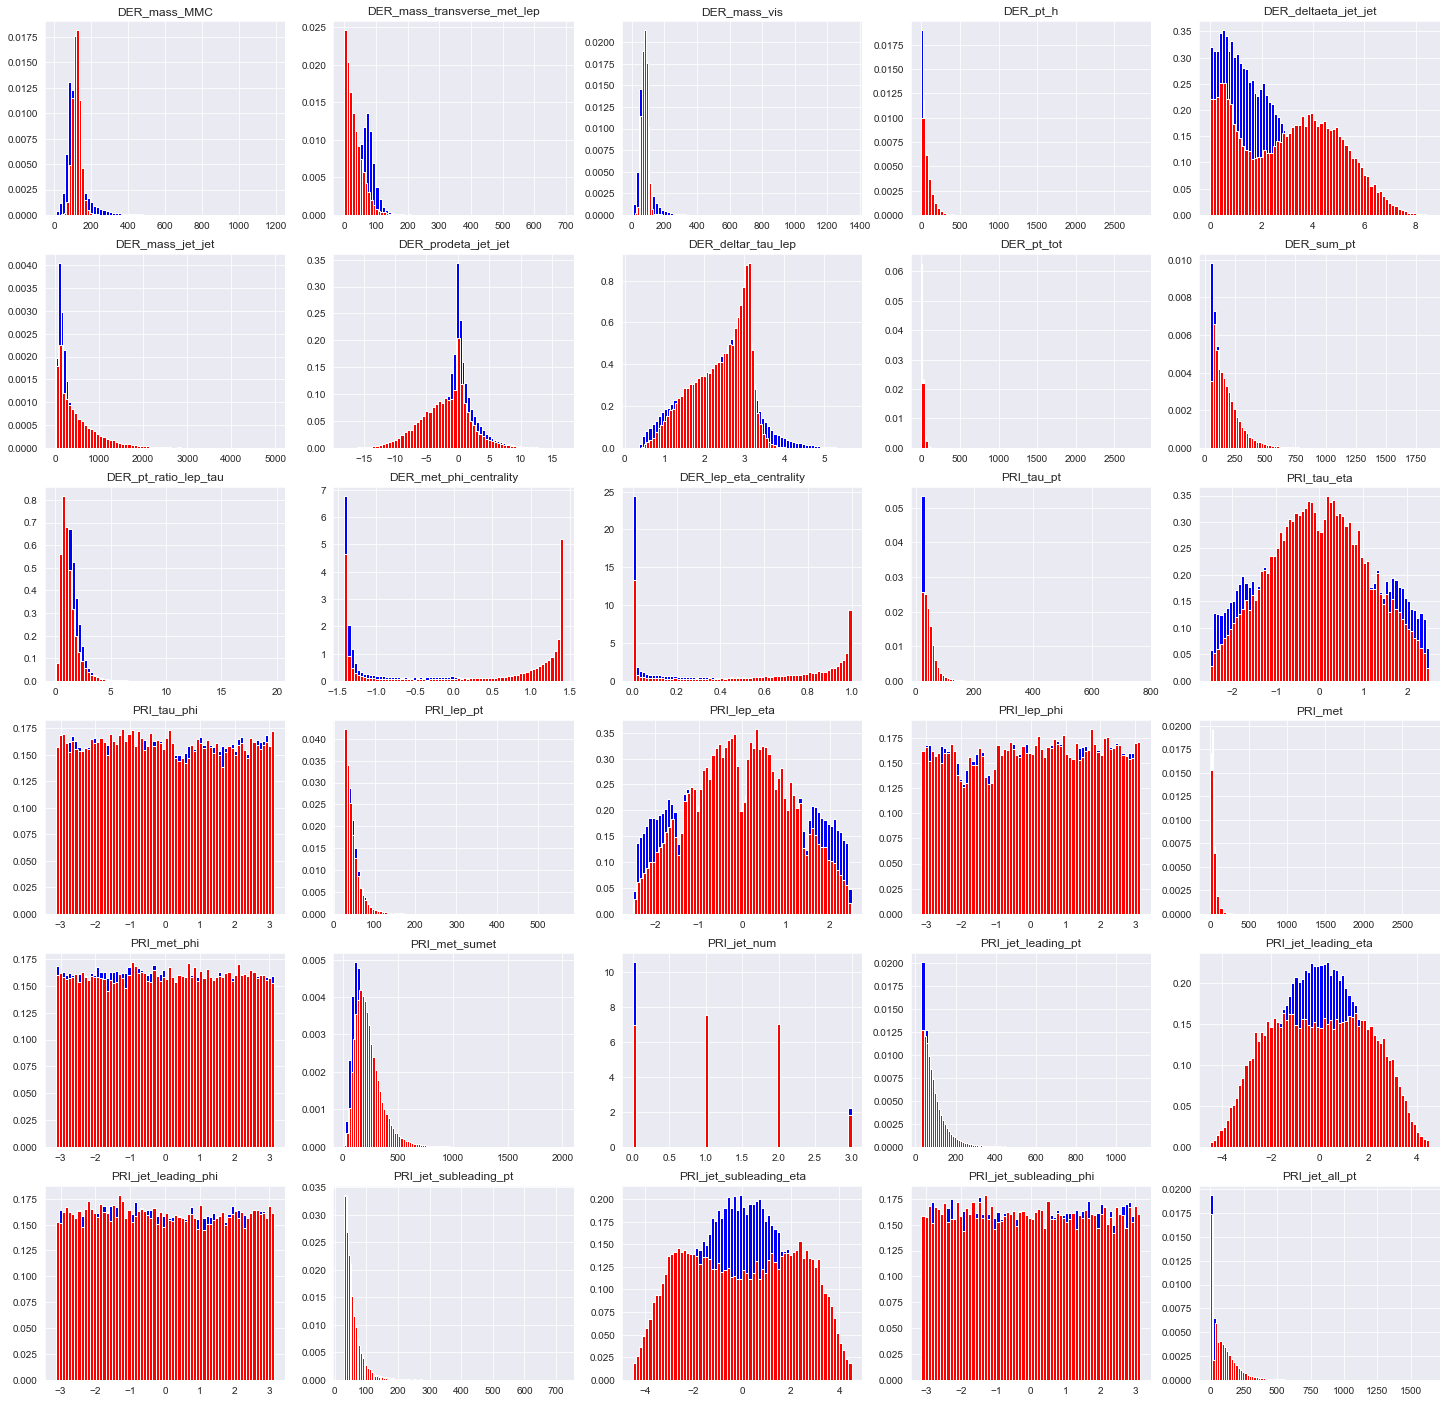

In [14]:
plt.subplots(figsize=(25,25))
X_b = X[y == -1]
X_s = X[y == 1]
for i in range(0, N_feature):
    plt.subplot(6,5,i+1).set_title(features_name[i])
    tmp_b = X_b[:,i]
    tmp_s = X_s[:,i]
    plt.hist(tmp_b[tmp_b != -999] ,bins = 70, histtype ='bar',color='b',density=True)
    plt.hist(tmp_s[tmp_s != -999] ,70, histtype ='bar',color='r',density=True)

## Deep into the Categorical feature PRI_jet_num (index 22)

In [15]:
X_PRI_jet_num = X[:,22]
X_test_PRI_jet_num = X_Test[:,22]
N = X.shape[0]
N_test = X_Test.shape[0]
for i in range(0,4):
    print(f'----In Category {i}------')
    print(f'There are {X_PRI_jet_num[X_PRI_jet_num==i].shape[0]} '
          f'({X_PRI_jet_num[X_PRI_jet_num==i].shape[0]/N}) data sample in train data')
    print(f'There are {X_test_PRI_jet_num[X_test_PRI_jet_num==i].shape[0]} '
          f'({X_test_PRI_jet_num[X_test_PRI_jet_num==i].shape[0]/N_test}) data sample in test data')

----In Category 0------
There are 99913 (0.399652) data sample in train data
There are 227458 (0.40028649967091257) data sample in test data
----In Category 1------
There are 77544 (0.310176) data sample in train data
There are 175338 (0.30856436915517793) data sample in test data
----In Category 2------
There are 50379 (0.201516) data sample in train data
There are 114648 (0.20176052991880164) data sample in test data
----In Category 3------
There are 22164 (0.088656) data sample in train data
There are 50794 (0.08938860125510789) data sample in test data


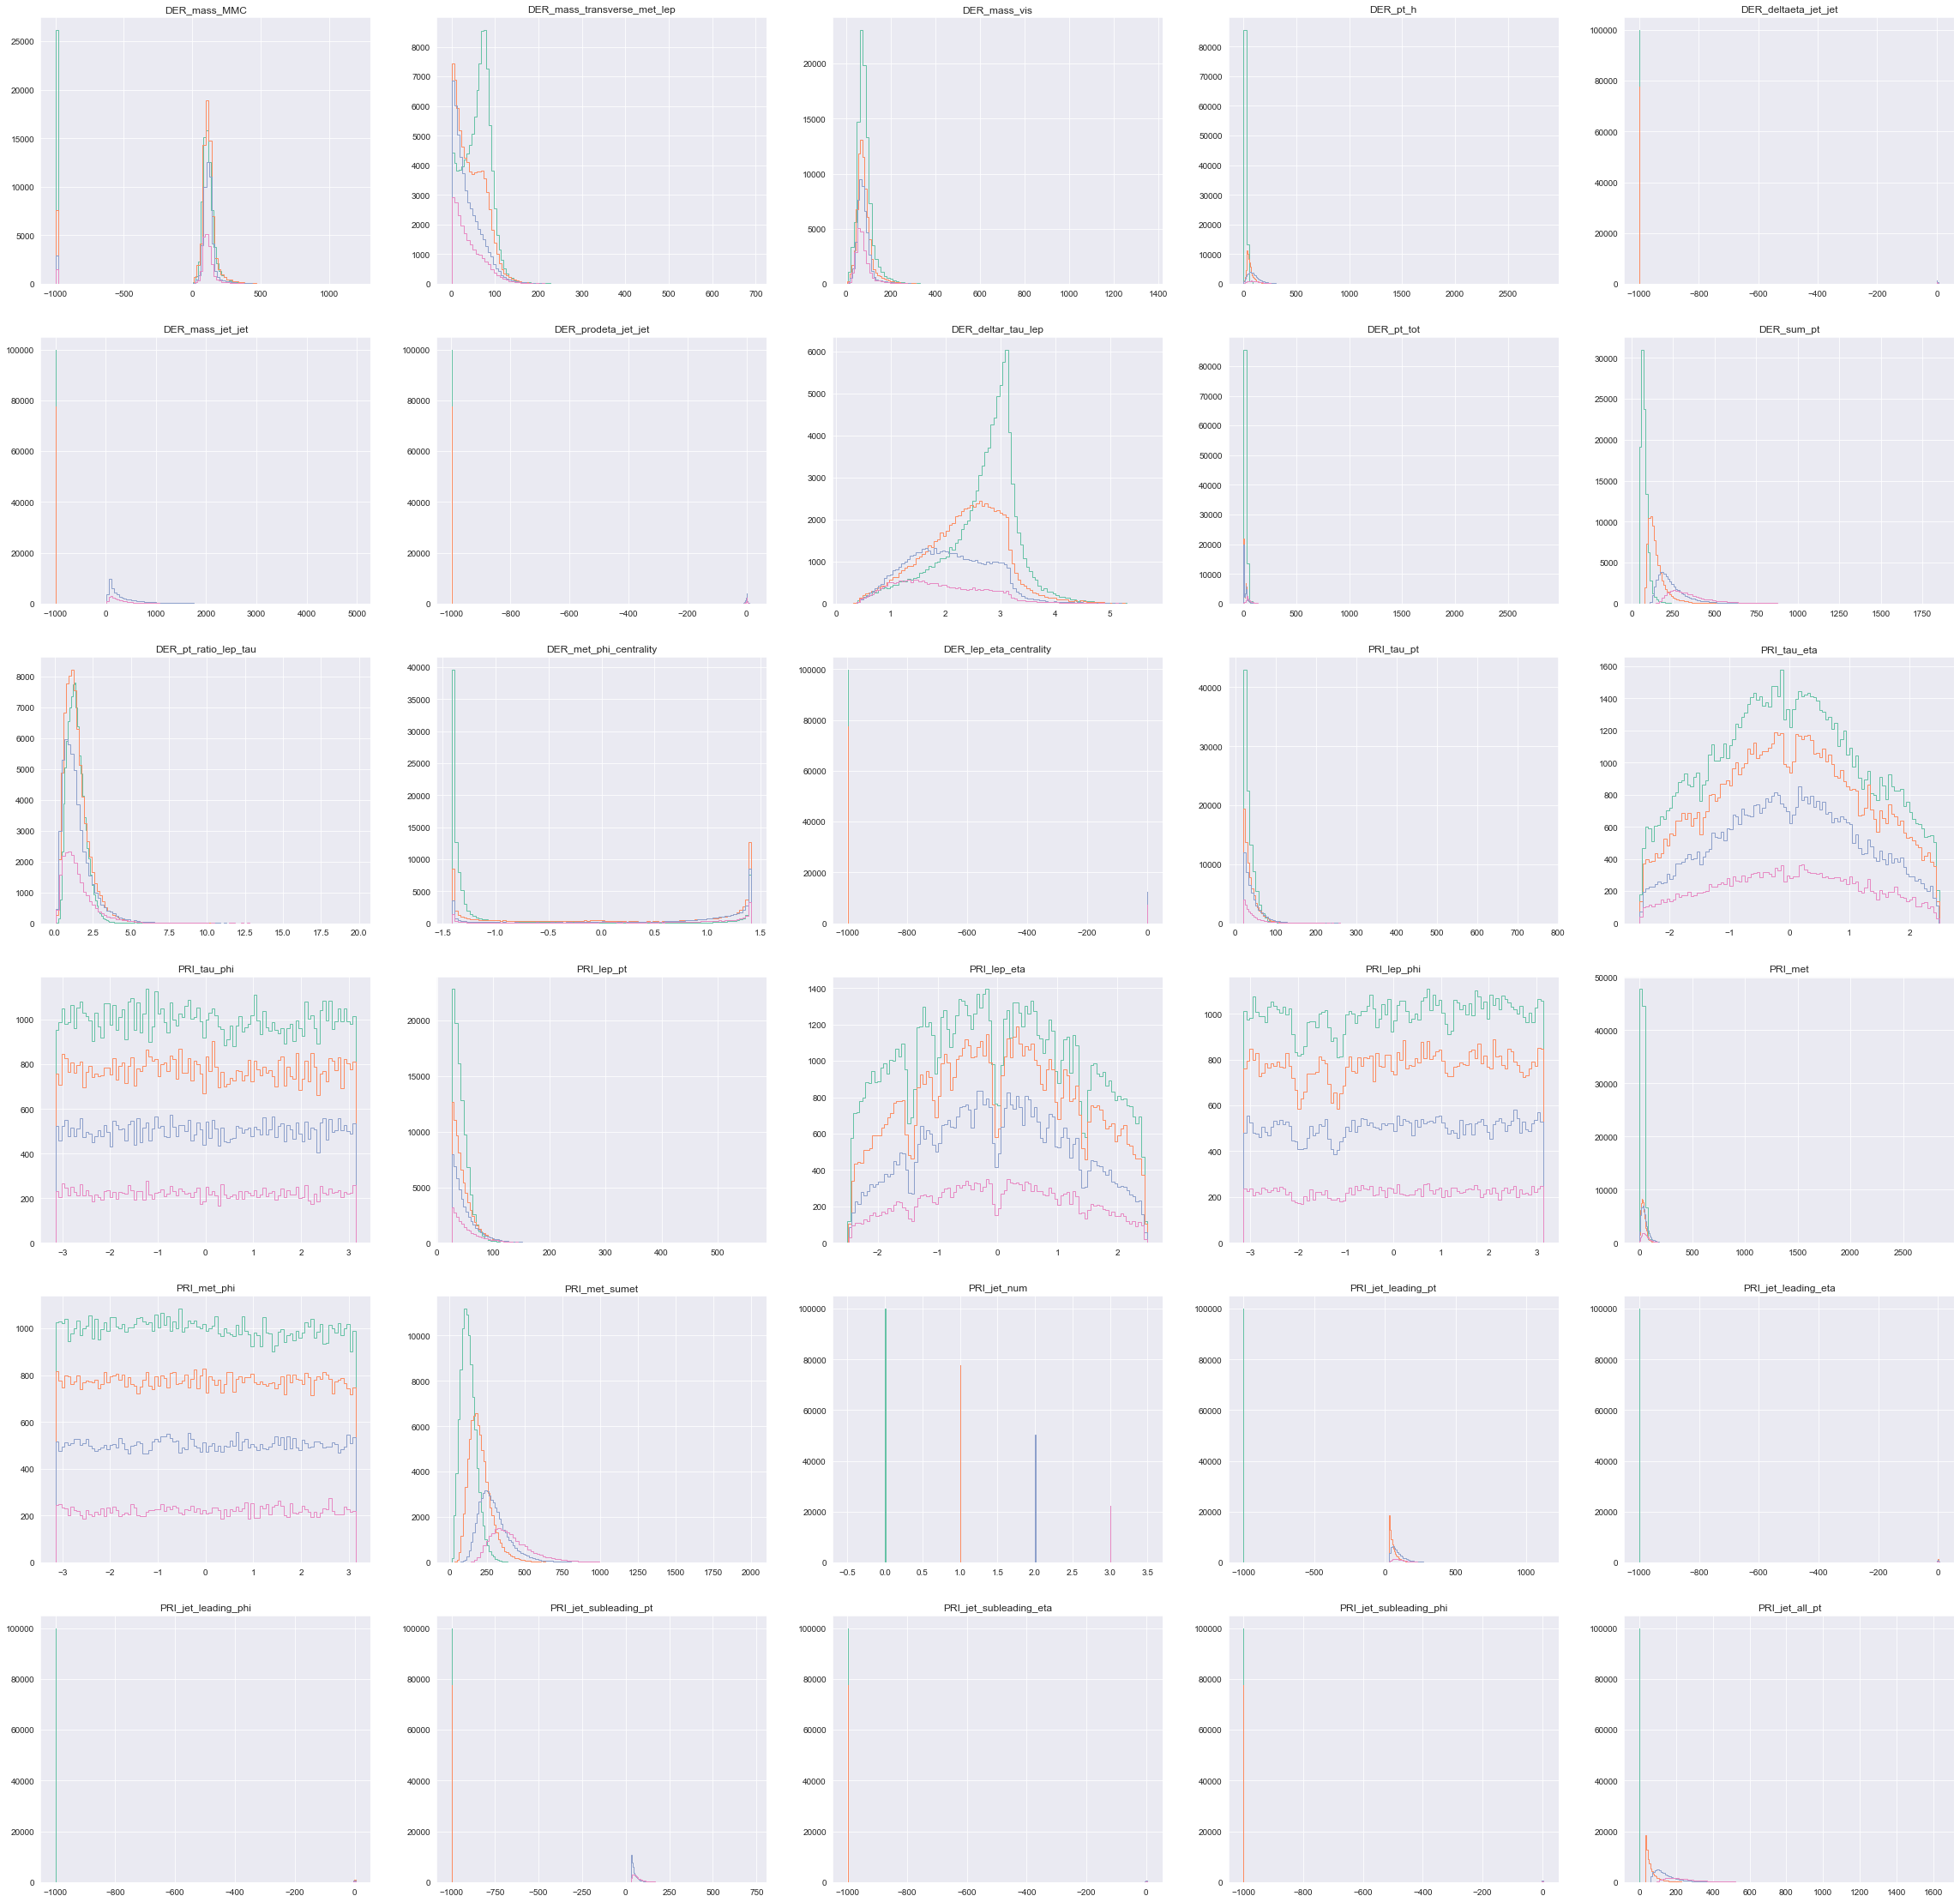

In [50]:
plt.subplots(figsize=(40,40))
X_jet_0 = X[X[:,22] == 0]
X_jet_1 = X[X[:,22] == 1]
X_jet_2 = X[X[:,22] == 2]
X_jet_3 = X[X[:,22] == 3]
colors = sns.color_palette("Set2",4)

for i in range(0, N_feature):
    plt.subplot(6,5,i+1).set_title(features_name[i])
    plt.hist(X_jet_0[:,i] ,bins = 100, histtype ='step',color=colors[0])
    plt.hist(X_jet_1[:,i] ,100, histtype ='step',color=colors[1])
    plt.hist(X_jet_2[:,i] ,100, histtype ='step',color=colors[2])
    plt.hist(X_jet_3[:,i] ,100, histtype ='step',color=colors[3])

The above polt shows there are some feature have quite different distribution with different `PRI_Jet_num`. To take a closer look, we print the count of each feature in different `PRI_Jet_num` (without the missing value).

In [51]:
X_jet_0[X_jet_0 != -999] =1
X_jet_0[X_jet_0 == -999] =0
count_0 = np.sum(X_jet_0,axis=0)

X_jet_1[X_jet_1 != -999] =1
X_jet_1[X_jet_1 == -999] =0
count_1 = np.sum(X_jet_1,axis=0)

X_jet_2[X_jet_2 != -999] =1
X_jet_2[X_jet_2 == -999] =0
count_2 = np.sum(X_jet_2,axis=0)

X_jet_3[X_jet_3 != -999] =1
X_jet_3[X_jet_3 == -999] =0
count_3 = np.sum(X_jet_3,axis=0)

In [52]:
count_jet_number = np.c_[count_0,count_1,count_2,count_3]
count_jet_number

array([[73790., 69982., 47427., 20687.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [    0.,     0., 50379., 22164.],
       [    0.,     0., 50379., 22164.],
       [    0.,     0., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [    0.,     0., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [99913., 77544., 50379., 22164.],
       [    0., 77544., 50379., 22164.],
       [    0., 

Here we can see `4,5,6,12,26,27,28` column are all missing in jet_num 0 and 1, and `23,24,25` are all missing in jet_num 0. And there are no missing value in these columns in jet_num 2 and 3. Due to this observation, we believe this is a good idea to training four different models with different jet_num.